In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns
sns.set_style("whitegrid")
# Bigger font
# sns.set_context("poster")
sns.set_context("talk")
# Figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 4
# np.random.seed(123)

In [2]:
from sklearn.metrics import roc_auc_score
dataframe = pd.read_csv('data/loan_prediction.csv')
dataframe.head(2)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,5849,0.0,0.0,360.0,1.0,1
1,4583,1508.0,128.0,360.0,1.0,0


In [3]:
from sklearn.model_selection import train_test_split
X = dataframe.iloc[:, :-1]
y = dataframe.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

## Stacking

- It is a **meta modelling** technique
- Wolpert introduced stacking in 1992

Making predictions of a number of models in a hold-out set and then using a different **(meta) model** to train on these predictions.

It is different than the other methods because here we do predictions not using the **input data** but using the **predictions of some models**. Some models have more contribution than others.

I think this is not the whole idea but it is what the model essentially does.

#### Training steps

1. Splitting the training set into **2 disjoint subsets**.
2. **Train several base learners on the first subset**.
3. Make **predictions** with the base learners on the second subset, which is like a validation set.
4. Stacking part: **Stack the predictions** from 3 as columns
5. Use those **stacked predictions as the new input** of another learning algorithm (called a **meta-model**).

### Example

Here I am splitting the training set X_train. So it's not like the first splitting

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# split the data into 2 subsets
training, valid, ytraining, yvalid = train_test_split(X_train,y_train,test_size=0.5)

# base models
model1 = RandomForestClassifier(n_estimators=100,max_depth=100)
model2 = LogisticRegression(C=20, max_iter=1000)

model1.fit(training,ytraining)
model2.fit(training,ytraining)

# predictions
preds1 = model1.predict(valid)
preds2 = model2.predict(valid)

# stacking part
stacked_predictions = np.column_stack((preds1,preds2))

# META MODEL
meta_model = LogisticRegression()
meta_model.fit(stacked_predictions,yvalid)

print(stacked_predictions.shape)

(215, 2)


But, there is no way to use the final model after its input has the size of the "number of base learners".

That's why the new data or test data or X_test has to be the input of the base learners too so as to have the predictor.

#### Testing steps

1. Predict the base learners on the test data
2. Stacking part: Stack the predictions from 1 as columns
3. Use the already trained meta-model to predict the final predictions

In [5]:
# predictions
test_preds1 = model1.predict(X_test)
test_preds2 = model2.predict(X_test)

# stacking part
stacked_test_predictions = np.column_stack((test_preds1,test_preds2))

# stacking model predictions
final_predictions = meta_model.predict(stacked_test_predictions)
final_predictions

auc = roc_auc_score(y_test, final_predictions)
auc

0.6769566367001587

### Parameters that control stacking

#### The right train-validation split
For time sensitive data
- Your train is in the past and validation in the future
- Test data is in the future

#### Diversity
Diversity is important and it doesn't mean only different algorithms. It can be
- Different algorithms
- Different input features but same model

#### Meta-model
- No limit on how many models to stack but it plateaus after N models
- The meta-model is normally simple

### Conclusions

If we used stacking on the first example, we would have this result

![](images/stacking_ideal.png)
Stacking finds the 50, but it doesn't do it as an ideal model
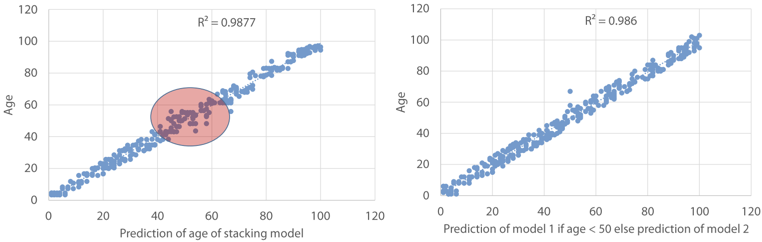

## Coding stacking

### StackNet

Scalable framework that utilizes stacking to combine multiple models in a NN architecture of multiple levels. This one is kaz-Anova's library 

https://www.coursera.org/learn/competitive-data-science/lecture/s8RLi/stacknet

- There's deep stacking
- They are computationally expensive, so they may not be great for production

but it doesn't seem too easy to use so I may review it after I make use of the other methods.

### Other libraries

There are libraries like H2O or mlxtend, but kagglers seem to do implement their own stacking models. 

In [6]:
from mlxtend.classifier import StackingClassifier

model1 = RandomForestClassifier(n_estimators=1000,max_depth=100)
model2 = LogisticRegression(C=10, max_iter=1000)
models = [model1, model2]

In [7]:
stacking_clf = StackingClassifier(classifiers = models,
                                 meta_classifier = model2)

stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)
accuracy = roc_auc_score(y_test, y_pred)
accuracy

0.6691565309360127